In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import sklearn
import math

# Aux data preparation functions

In [2]:
def parse_emotion(emotion,emo_dict):
    return emo_dict[emotion]
def process_pixels(pixel_str):
    pixel_lst=[int(px) for px in pixel_str.split()]
    return pixel_lst
def show_some_emotion(df,num=[3,5]):
    faces=np.random.choice(range(len(df)),size=num[0]*num[1],replace=False)
    fig,axes=plt.subplots(num[0],num[1],figsize=(num[1]*2.5,num[0]*2.5))
    for i in range(num[0]):
        for j in range(num[1]):
            face=faces[i*num[1]+j]
            axes[i][j].imshow(np.array(df['pixels'].iloc[face]).reshape(48,48),cmap='gray')
            axes[i][j].set_title(df['emotion'].iloc[face])
    plt.tight_layout()
    plt.show()
def filter_emotions(df,keep_emotions):
    return df[df['emotion'].isin(keep_emotions)]
def equalize_groups(df,label):
    largest_group=df.groupby(label).count().max()[0]
    upscaled_groups=[]
    for _,group in df.groupby(label):
        group_ratio=int(round(1.0*largest_group/len(group)))
        upscaled_groups.extend([group]*group_ratio)
    return pd.concat(upscaled_groups,axis=0,ignore_index=True)
def normalize_pixels(pixel_lst,factor=255):
    if factor=='norm':
        px_avg=np.mean(pixel_lst)
        px_std=np.std(pixel_lst)
        pixel_lst=[(1.0*px-px_avg)/px_std for px in pixel_lst]
    elif factor=='max':
        px_max=np.max(pixel_lst)
        pixel_lst=[1.0*px/px_max for px in pixel_lst]
    else:
        pixel_lst=[1.0*px/factor for px in pixel_lst]
    return pixel_lst
def prepare_data(faces_file,emo_dict,
                 emo_filter=False,
                 equalize=True,
                 sample=False,random_state=None,
                 plot_sample=[3,5],
                 normalize=255):
    df=pd.read_csv(faces_file,usecols=[0,1])
    df['emotion']=df['emotion'].map(lambda emotion: parse_emotion(emotion,emo_dict))
    if emo_filter!=False:
        df=filter_emotions(df,keep_emotions)
    if equalize:
        df=equalize_groups(df,'emotion')
    if sample:
        df=df.sample(sample,random_state=random_state)
    df['pixels']=df['pixels'].map(process_pixels)
    if plot_sample!=False:
        show_some_emotion(df,plot_sample)
    if normalize:
        df['pixels']=df['pixels'].map(lambda pixels: normalize_pixels(pixels,factor=normalize))
    X=np.array(df['pixels'].values.tolist())
    labels=list(df['emotion'].unique())
    Y=df['emotion'].map(lambda x: labels.index(x)).values
    return X,Y

# Aux NN functions

In [3]:
def one_hot_encoder(v):
    return np.eye(v.max()+1)[v]
def one_hot_decoder(v):
    return np.argmax(v,axis=1)
def sigmoid(v,derivate=False):
    if derivate:
        return v*(1-v)
    else:
        return 1/(1+np.exp(-v))
def relu(v,derivate=False):
    if derivate:
        return (v>0)
    else:
        return v*(v>0)
def tanh(v,derivate=False):
    if derivate:
        return 1-v*v
    else:
        return np.tanh(v)
def softmax(v):
    expv=np.exp(v)
    if v.shape[0]>1:
        return expv/expv.sum(axis=1,keepdims=True)
    else:
        return expv/expv.sum(axis=1)
def cross_entropy_cost(Y,P):
    return -(Y*np.log(P)).mean()
def accuracy(Y,P):
    return (Y==P).mean()
def rmse(Y,P):
    return np.sqrt(((P-Y)**2).mean())

# La classe

In [4]:
class NN_01(object):
    def __init__(self,
                 net_structure,
                 f_encode_Y=one_hot_encoder,
                 f_decode_Y=one_hot_decoder,
                 f_transfer=sigmoid,
                 f_output=lambda v: softmax(sigmoid(v)),
                 f_cost=cross_entropy_cost,
                 f_accuracy=accuracy):
        self.net_structure=net_structure
        self.f_encode_Y=f_encode_Y
        self.f_decode_Y=f_decode_Y
        self.f_transfer=f_transfer
        self.f_output=f_output
        self.f_cost=f_cost
        self.f_accuracy=f_accuracy
    def train(self,X,Y,W_0=None,
              frac_test=0.2,random_state=None,
              learning_rate=10e-7,regularization=0,num_rounds=100001,
              report_step=100,print_every=5000,print_acc=True,plot_cost=True):
        self.training_report=[]
        X,Y=sklearn.utils.shuffle(X,Y,random_state=random_state)
        num_test=int(frac_test*X.shape[0])
        X_train,Y_train=X[:-num_test],Y[:-num_test]
        X_test,Y_test=X[-num_test:],Y[-num_test:]
        eY_train,eY_test=self.f_encode_Y(Y_train),self.f_encode_Y(Y_test)
        if W_0!=None:
            self.W=W_0
        else:
            self.W=self.populate_W(X_train,eY_train)
        peY_train,peY_test=self.feed_forward(X_train),self.feed_forward(X_test)
        global_start=datetime.datetime.now()
        reporting_start=datetime.datetime.now()
        for n in range(num_rounds):
            delta=peY_train[-1]-eY_train
            for l in reversed(range(len(self.W))):
                gradient,new_delta=self.derivate_layer(self.W[l],peY_train[l],delta)
                delta=new_delta
                self.W[l]=self.W[l]*(1-learning_rate*regularization)-learning_rate*gradient
            peY_train,peY_test=self.feed_forward(X_train),self.feed_forward(X_test)
            if n % report_step==0:
                c_train,c_test=self.f_cost(eY_train,peY_train[-1]),self.f_cost(eY_test,peY_test[-1])
                pY_train,pY_test=self.f_decode_Y(peY_train[-1]),self.f_decode_Y(peY_test[-1])
                acc_train,acc_test=self.f_accuracy(Y_train,pY_train),self.f_accuracy(Y_test,pY_test)
                global_duration=(datetime.datetime.now()-global_start).total_seconds()
                if print_every and n % print_every==0:
                    global_left=global_duration*(num_rounds-n+1)/(n+1)
                    reporting_duration=(datetime.datetime.now()-reporting_start).total_seconds()
                    reporting_start=datetime.datetime.now()
                    print('{:5d} '.format(n)),
                    print('{:0.5f} {:0.5f} '.format(acc_train,acc_test)),
                    print('{:0.5f} {:0.5f} '.format(c_train,c_test)),
                    print('{:7.2f} {:7.2f}  {:7.2f}'.format(reporting_duration,global_duration,global_left))
                self.training_report.append([n,acc_train,acc_test,c_train,c_test,global_duration])
        if plot_cost:
            plt.plot([r[3] for r in self.training_report])
            plt.plot([r[4] for r in self.training_report])
            plt.show()
    def populate_W(self,X,T):
        net_structure=[X[0].size]+self.net_structure+[T[0].size]
        W=[]
        for i in range(len(net_structure)-1):
            nodes_this=net_structure[i]+1
            nodes_next=net_structure[i+1]
            W.append(np.random.randn(nodes_this,nodes_next)/np.sqrt(nodes_this+nodes_next))
        return W
    def derivate_layer(self,W_layer,layer,delta):
        next_delta=delta.dot(W_layer[:-1,:].T)*self.f_transfer(layer,derivate=True)
        layer=np.append(layer,np.ones((layer.shape[0],1)),1)
        return layer.T.dot(delta),next_delta
    def predict(self,X):
        return self.f_decode_Y(self.feed_forward(X))
    def feed_forward(self,X):
        v=[X]
        for l in range(len(self.W)-1):
            v.append(self.f_transfer(self.process_layer(v[-1],self.W[l])))
        v.append(self.f_output(self.process_layer(v[-1],self.W[-1])))
        return v
    def process_layer(self,X,W):
        X=np.append(X,np.ones((X.shape[0],1)),1)
        return X.dot(W)

# Data preparation

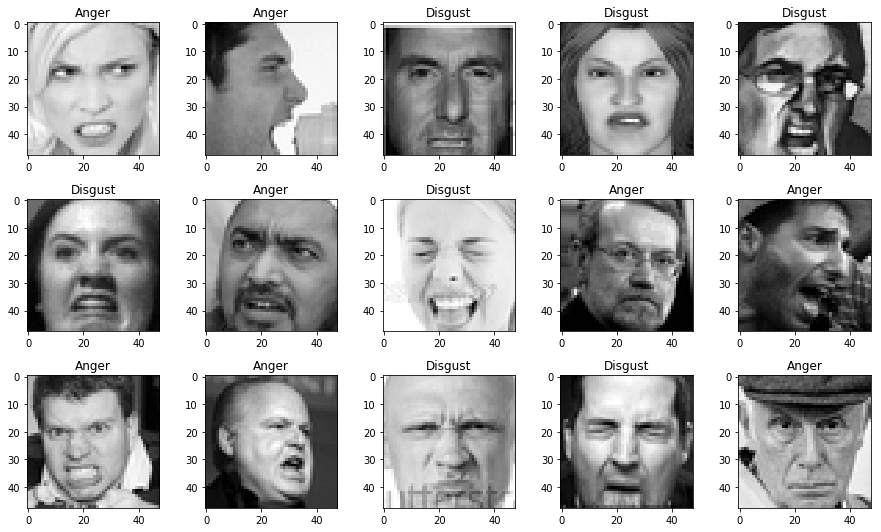

((9876, 2304), (9876,))

In [5]:
file_name='data/fer2013.csv.bz2'
emo_dict={0:'Anger',1:'Disgust',2:'Fear',3:'Happiness',4:'Sadness',5:'Surprise',6:'Neutrality'}
keep_emotions=['Anger','Disgust']
X,Y=prepare_data(file_name,emo_dict,
                 emo_filter=keep_emotions,
                 equalize=True,
                 sample=False,random_state=None,
                 plot_sample=[3,5],
                 normalize=255)
X.shape,Y.shape

# Binary classifier

## Sigmoid

In [6]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=lambda v: v.reshape((-1,1)),
            f_decode_Y=lambda v: v.ravel().round().astype(int),
            f_transfer=sigmoid,
            f_output=sigmoid,
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.49918 0.51089  1.83629 1.77936     0.55    0.55  2744.85
  500  0.57879 0.56962  0.33675 0.32887   275.16  275.71  2477.56
 1000  0.59499 0.58430  0.33067 0.32365   275.33  551.04  2203.05
 1500  0.60208 0.59089  0.32546 0.31944   274.06  825.10  1925.04
 2000  0.62144 0.60709  0.32009 0.31520   275.61 1100.70  1651.33
 2500  0.63195 0.60506  0.31441 0.31091   289.66 1390.36  1390.92
 3000  0.64359 0.60911  0.30869 0.30650   300.40 1690.77  1127.93
 3500  0.65409 0.62278  0.30329 0.30191   282.43 1973.19   846.54
 4000  0.66017 0.62835  0.29816 0.29735   285.24 2258.43   565.60
 4500  0.67435 0.63747  0.29316 0.29304   281.11 2539.54   283.24
 5000  0.68295 0.64709  0.28761 0.28837   282.12 2821.67     1.13


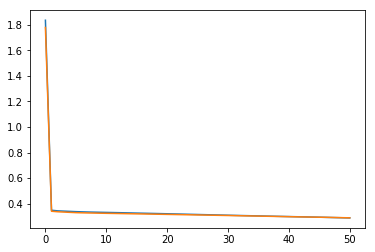

CPU times: user 1h 45min 2s, sys: 52min 18s, total: 2h 37min 20s
Wall time: 47min 2s


In [7]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [8]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=lambda v: v.reshape((-1,1)),
            f_decode_Y=lambda v: v.ravel().round().astype(int),
            f_transfer=relu,
            f_output=sigmoid,
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.49816 0.50329  0.02738 0.05644     0.46    0.46  2304.64
  500  0.60524 0.61013  0.29428 0.29684   233.80  234.26  2105.11
 1000  0.61182 0.61772  0.28773 0.29186   238.28  472.54  1889.22
 1500  0.62435 0.62228  0.28854 0.29258   254.27  726.81  1695.73
 2000  0.62878 0.62937  0.28442 0.28902   244.89  971.70  1457.80
 2500  0.63941 0.63342  0.28168 0.28629   243.81 1215.51  1216.00
 3000  0.65523 0.65316  0.28434 0.28877   241.32 1456.83   971.87
 3500  0.66561 0.66633  0.28686 0.29191   245.80 1702.63   730.46
 4000  0.67321 0.66532  0.29067 0.29675   246.49 1949.11   488.13
 4500  0.68358 0.67646  0.28364 0.29124   244.93 2194.04   244.70
 5000  0.69687 0.68405  0.27786 0.28569   264.54 2458.59     0.98


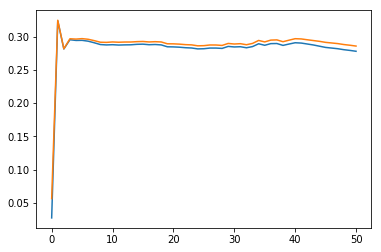

CPU times: user 1h 41min 11s, sys: 50min 56s, total: 2h 32min 8s
Wall time: 40min 59s


In [9]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [10]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=lambda v: v.reshape((-1,1)),
            f_decode_Y=lambda v: v.ravel().round().astype(int),
            f_transfer=tanh,
            f_output=sigmoid,
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.49994 0.50734  3.30858 3.22839     0.68    0.68  3376.91
  500  0.59220 0.59392  0.33915 0.33760   287.71  288.39  2591.46
 1000  0.60246 0.60354  0.32846 0.32851   270.82  559.21  2235.72
 1500  0.60967 0.61316  0.32246 0.32389   283.03  842.24  1965.03
 2000  0.61853 0.62430  0.31774 0.32035   277.79 1120.03  1680.32
 2500  0.63131 0.62025  0.31300 0.31717   280.87 1400.90  1401.46
 3000  0.64055 0.63038  0.30834 0.31436   284.59 1685.49  1124.41
 3500  0.65004 0.63494  0.30395 0.31172   297.10 1982.59   850.57
 4000  0.66295 0.64203  0.29930 0.30918   272.14 2254.73   564.67
 4500  0.67321 0.65418  0.29468 0.30590   294.65 2549.38   284.33
 5000  0.68156 0.66076  0.28914 0.30131   293.76 2843.14     1.14


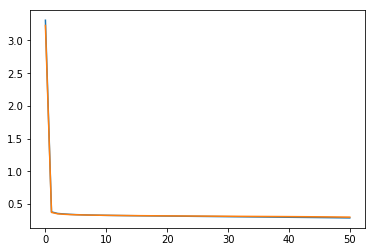

CPU times: user 1h 44min 16s, sys: 54min 39s, total: 2h 38min 56s
Wall time: 47min 23s


In [11]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# 2 class classifier

## Sigmoid

In [12]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.46500 0.45722  0.35233 0.35217     0.56    0.56  2781.17
  500  0.57891 0.58684  0.34368 0.34378   298.64  299.20  2688.59
 1000  0.61549 0.60861  0.33790 0.33798   296.90  596.10  2383.20
 1500  0.64941 0.64557  0.32759 0.32800   284.11  880.21  2053.63
 2000  0.68131 0.66329  0.31519 0.31689   282.60 1162.81  1744.51
 2500  0.70295 0.69165  0.30341 0.30620   283.47 1446.28  1446.85
 3000  0.72598 0.71392  0.29171 0.29583   288.35 1734.63  1157.19
 3500  0.74889 0.73165  0.28014 0.28602   299.96 2034.59   872.88
 4000  0.75914 0.73772  0.27260 0.28081   302.32 2336.91   585.25
 4500  0.78661 0.75797  0.26073 0.27029   292.69 2629.60   293.28
 5000  0.78977 0.76557  0.25711 0.26757   287.42 2917.02     1.17


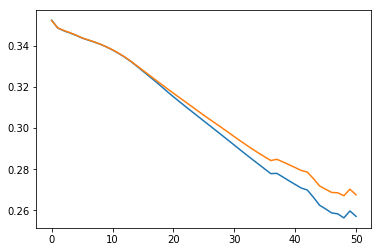

CPU times: user 1h 43min 14s, sys: 54min 23s, total: 2h 37min 37s
Wall time: 48min 37s


In [13]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [14]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=relu,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.50108 0.48911  0.40518 0.41149     0.46    0.46  2305.94


/home/ggomarr/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp


  500  0.66662 0.66430  0.31600 0.31498   242.94  243.40  2187.23
 1000  0.64283 0.62481  0.33602 0.34521   245.13  488.53  1953.15
 1500  0.57891 0.55696  0.33814 0.34889   241.07  729.60  1702.25
 2000  0.65106 0.65975  0.32771 0.32414   267.31  996.92  1495.63
 2500  0.63587 0.64101  0.33674 0.33472   251.32 1248.24  1248.74
 3000  0.62119 0.62177  0.33531 0.33475   235.78 1484.03   990.01
 3500  0.60157 0.60152  0.34364 0.34088   245.55 1729.57   742.02
 4000  0.61726 0.60506  0.32955 0.33264   240.68 1970.26   493.43
 4500  0.61271 0.61367  0.32901 0.33060   245.25 2215.51   247.10
 5000  0.62815 0.60506  0.31558 0.32536   255.34 2470.85     0.99


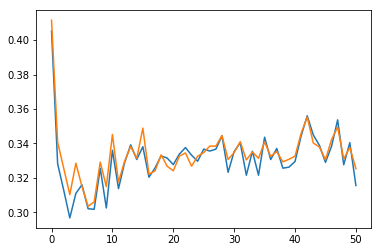

CPU times: user 1h 37min 9s, sys: 51min 51s, total: 2h 29min 1s
Wall time: 41min 11s


In [15]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [6]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=tanh,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.51196 0.51089  0.37621 0.37694     0.53    0.53  2665.98
  500  0.62701 0.62076  0.31803 0.32051   267.00  267.53  2404.02
 1000  0.67713 0.66481  0.30043 0.30568   263.66  531.19  2123.68
 1500  0.67586 0.66987  0.30541 0.30994   260.08  791.26  1846.10
 2000  0.74168 0.70734  0.27540 0.28845   260.48 1051.75  1577.88
 2500  0.71852 0.68759  0.29023 0.30298   260.32 1312.07  1312.59
 3000  0.75193 0.72203  0.27441 0.28803   260.37 1572.44  1048.99
 3500  0.74965 0.70886  0.28313 0.29662   265.76 1838.20   788.63
 4000  0.74143 0.72354  0.27695 0.28683   264.27 2102.48   526.54
 4500  0.70928 0.68911  0.29442 0.30638   259.92 2362.40   263.48
 5000  0.72092 0.68911  0.28542 0.30064   259.52 2621.92     1.05


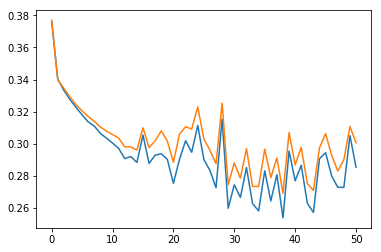

CPU times: user 1h 41min 19s, sys: 51min 35s, total: 2h 32min 54s
Wall time: 43min 42s


In [7]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0,num_rounds=5001,print_every=500,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)